In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW

In [5]:
# Đường dẫn đến tập dữ liệu
file_path = "../data/comment_book.txt"
df = pd.read_csv(file_path, names=["user", "book", "comment", "sentiment"])

In [6]:
# Lấy mẫu nhỏ để thử nghiệm (nếu cần)
df = df.sample(n=1000, random_state=42) if len(df) > 1000 else df

In [7]:
# Chuẩn bị dữ liệu
sentiment_map = {"positive": 2, "neutral": 1, "negative": 0}
df["sentiment"] = df["sentiment"].map(sentiment_map)

X = df["comment"].values
y = df["sentiment"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Tiền xử lý với DistilBERT Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_data(texts, max_length=128):
    return tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

train_encodings = tokenize_data(X_train)
test_encodings = tokenize_data(X_test)

train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels)
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], test_labels)

# Giảm batch size để chạy nhanh hơn
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Khởi tạo mô hình DistilBERT
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

d:\Ecommerce\.venv\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased a

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [9]:
# Tối ưu hóa với AdamW
optimizer = AdamW(model.parameters(), lr=2e-5)

In [10]:
# Hàm huấn luyện mô hình
def train_model(model, train_loader, epochs=1):  # Giảm số epoch để thử nghiệm
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

# Huấn luyện mô hình
train_model(model, train_loader)

Epoch 1, Loss: 1.1059


In [11]:
# Hàm đánh giá mô hình
def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    return np.array(predictions), np.array(true_labels)

# Đánh giá mô hình
y_pred, y_test_labels = evaluate_model(model, test_loader)

# Tính toán các chỉ số đánh giá
results = {
    "MAE": mean_absolute_error(y_test_labels, y_pred),
    "MSE": mean_squared_error(y_test_labels, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test_labels, y_pred)),
    "MAPE": mean_absolute_percentage_error(y_test_labels, y_pred)
}

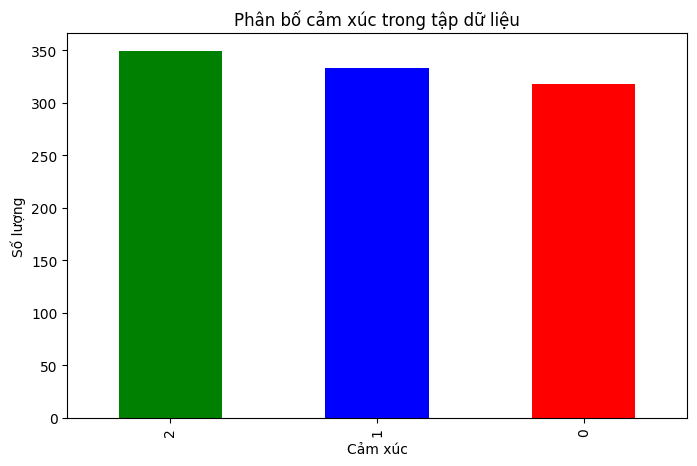

In [12]:
# Trực quan hóa kết quả
plt.figure(figsize=(8, 5))
df["sentiment"].value_counts().plot(kind="bar", color=["green", "blue", "red"])
plt.title("Phân bố cảm xúc trong tập dữ liệu")
plt.xlabel("Cảm xúc")
plt.ylabel("Số lượng")
plt.show()

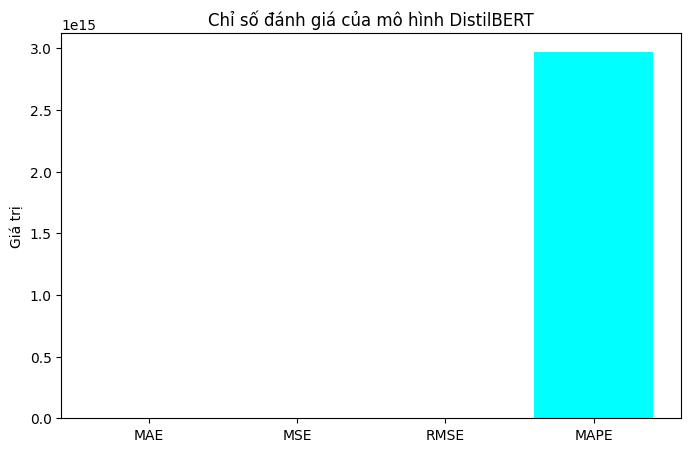

In [13]:
metrics_to_plot = ["MAE", "MSE", "RMSE", "MAPE"]
plt.figure(figsize=(8, 5))
plt.bar(metrics_to_plot, [results[m] for m in metrics_to_plot], color="cyan")
plt.title("Chỉ số đánh giá của mô hình DistilBERT")
plt.ylabel("Giá trị")
plt.show()

In [15]:
# In kết quả đánh giá
print("\nKết quả đánh giá mô hình DistilBERT:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")


Kết quả đánh giá mô hình DistilBERT:
MAE: 1.0100
MSE: 1.6700
RMSE: 1.2923
MAPE: 2972375754064527.5000


In [16]:
# Lưu mô hình để tái sử dụng
model.save_pretrained("distilbert_sentiment_model")
tokenizer.save_pretrained("distilbert_sentiment_model")

('distilbert_sentiment_model\\tokenizer_config.json',
 'distilbert_sentiment_model\\special_tokens_map.json',
 'distilbert_sentiment_model\\vocab.txt',
 'distilbert_sentiment_model\\added_tokens.json')